In [2]:
import sys
print(sys.executable)
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
import matplotlib.ticker as mtick
import seaborn as sns

from lifelines.datasets import load_waltons
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

from sklearn.manifold import TSNE
import sklearn
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from lifelines import CoxPHFitter
from statsmodels.stats.multitest import multipletests

D:\software\Miniconda\miniConda\envs\plot\python.exe


In [3]:
import time
import warnings

import numpy as np


from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import scipy.stats as stats    #stats.ttest_ind(a=group1, b=group2, equal_var=True)

from itertools import combinations
from scipy import stats
from scipy.stats import mannwhitneyu

from scipy.stats import levene

### Select the cancer type form TCGA

####  Select the cancer type form TCGA using the condition that Pearson correlation coefficients (r) between the DeSide-predicted tumor purity and CPE values are greater than 0.6 and the RMSEs are less than 0.15.


In [14]:
beter_pre = "LUAD"
beter_pre_list = beter_pre.split(',')   


### Read cell proportions predicted by deside

In [15]:

my_datasets ={}
t_sne_datasets = {}
ori_datasets ={}
new_deside_data_path = r'D:\EMT\EMT\data\xiongxin_raw_data_0914\2023_\all_predicted_cell_fraction_by_DeSide_20231110_02_D1+D2.csv'
new_deside_data = pd.read_csv(new_deside_data_path,index_col='sample_id')
new_deside_data.index = new_deside_data.index.str.rsplit('-',1).str[0]    # change index, for example: change "TCGA-C4-A0F1-01A" to "TCGA-C4-A0F1"    
new_deside_data  = new_deside_data.loc[:,['cancer_type','Plasma B cells','Non-plasma B cells','CD4 T','CD8 T effector','CD8 T (GZMK high)','Double-neg-like T','Cancer Cells','DC','Endothelial Cells','CAFs','Myofibroblasts','Macrophages','Mast Cells','NK','Neutrophils','Monocytes'
]]
# new_deside_data['B Cells'] = new_deside_data['Plasma B cells']+new_deside_data['Non-plasma B cells']
# new_deside_data['CD8 T'] =new_deside_data['CD8 T effector']+new_deside_data['CD8 T (GZMK high)']
# new_deside_data['Fibroblasts'] =new_deside_data['CAFs']+new_deside_data['Myofibroblasts']
# new_deside_data['T Cells'] =new_deside_data['CD8 T']+new_deside_data['CD4 T']+ new_deside_data['Double-neg-like T']   #1207
# new_deside_data['Lymphocytes'] =  new_deside_data['B Cells']+new_deside_data['T Cells']+new_deside_data['NK']
# new_deside_data['Monocytic_cells']= new_deside_data['Monocytes']+new_deside_data['Macrophages']+new_deside_data['DC']   #https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0059243&type=printable
# new_deside_data['Stromal_cells'] = new_deside_data['Fibroblasts']+new_deside_data['Endothelial Cells']
for i in beter_pre_list:
    cf_new = new_deside_data.loc[new_deside_data['cancer_type']==i,:]
    cf_new = cf_new.drop('cancer_type',axis=1,inplace=False)
    print(i,'----------------')
    print('The number of duplicate samples: ',cf_new.index.duplicated().sum())
    print('Duplicate samples id:',cf_new.index[cf_new.index.duplicated(keep='first') ])
    cf_new = cf_new[~cf_new.index.duplicated(keep='first')]    
    print('The number of samples after deleting the duplicated id: ',len(cf_new))
    ori_datasets[i] = cf_new
    cf_ = MinMaxScaler().fit_transform(cf_new)
    cf_ = pd.DataFrame(cf_,index=cf_new.index,columns= cf_new.columns)
    my_datasets[i] = cf_
    


LUAD ----------------
The number of duplicate samples:  2
Duplicate samples id: Index(['TCGA-44-4112', 'TCGA-44-3917'], dtype='object', name='sample_id')
The number of samples after deleting the duplicated id:  513


### Dealing with input data for survival analysis

In [16]:
#Dealing with input data for survival analysis, including 22 types of cancer.
# https://www.jianshu.com/p/f18f846ca602
#  For deceased samples, the "min(T,C)" column follows the "days_to_death".
# For surviving samples, the "min(T,C)" column follows the "days to last follow-up".

clinical_path = r'D:\EMT\EMT\data\xiongxin_raw_data_0914\2022\clinical_data\original_download\22_cancer_type\clinical.cases_selection.2023-03-23\clinical.csv'

clinical_df = pd.read_csv(clinical_path,index_col='case_submitter_id')   #Don't change the variable name, delet_miss_in_clinical() fuction will use this variable.
clinical_df = clinical_df[['days_to_death','vital_status','days_to_last_follow_up']]
clinical_df.replace("'--", np.NaN, inplace=True)
clinical_df['days_to_death'] = clinical_df['days_to_death'].astype('float64') 
clinical_df['days_to_last_follow_up'] = clinical_df['days_to_last_follow_up'].astype('float64') 

clinical_df = clinical_df[~clinical_df.index.duplicated(keep='first')]       # Delete the duplicated ID

print('The number of duplicate samples: ',clinical_df.index.duplicated().sum())



clinical_df.loc[clinical_df['vital_status']=='Alive','min(T,C)']=clinical_df['days_to_last_follow_up']  #
clinical_df.loc[clinical_df['vital_status']=='Dead','min(T,C)']=clinical_df['days_to_death']   #
clinical_df['vital_status'] = clinical_df['vital_status'].replace('Alive', 0)    # The statu of Alive is 0
clinical_df['vital_status'] = clinical_df['vital_status'].replace('Dead', 1)     # The statu of Dead is 1
print("The number of instances where the 'vital_status' column is marked as 'Not Reported' ：",clinical_df['vital_status'].isin(['Not Reported']).sum())
clinical_df =clinical_df[~clinical_df['vital_status'].isin(['Not Reported'])]   #Delete samples where the "vital_status" column is marked as "Not Reported".
clinical_df.dropna(axis=0,subset=["vital_status"],inplace=True)     #Delete samples where the "vital_status" column is empty.
clinical_df.dropna(axis=0,subset=["min(T,C)"],inplace=True)       ##Delete samples where the "min(T,C)" column is empty.             

clinical_df.loc[clinical_df.index,:]  
clinical_df = clinical_df.loc[clinical_df['min(T,C)']>=0,:]     
clinical_df = clinical_df.loc[clinical_df['min(T,C)']>0,:]    #Keep samples where the "min(T,C)" column is greater than 0.
#clinical_df['vital_status'].value_counts()   
#clinical_df.info()    
clinical_df                       

The number of duplicate samples:  0
The number of instances where the 'vital_status' column is marked as 'Not Reported' ： 11


C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3106: DtypeWarning: Columns (3,8,17,20,48,137) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,days_to_death,vital_status,days_to_last_follow_up,"min(T,C)"
case_submitter_id,,,,
TCGA-A7-A0DA,NaN,0,1085.0,1085.0
TCGA-BH-A0BD,NaN,0,554.0,554.0
TCGA-A8-A0AB,NaN,0,518.0,518.0
TCGA-B6-A1KC,NaN,0,1326.0,1326.0
TCGA-A8-A07I,NaN,0,426.0,426.0
...,...,...,...,...
TCGA-12-1089,177.0,1,177.0,177.0
TCGA-06-5411,254.0,1,254.0,254.0
TCGA-28-1753,NaN,0,37.0,37.0


In [17]:
def delet_miss_in_clinical(sub_cf,clinical_df=clinical_df,time_unit='Days'):
    '''Delete cases from the subcluster that lack clinical information (such as LGG tumors) and return the clinical information of the corresponding cases. print.clinical_df
    '''
    judge_F = sub_cf.index.isin(clinical_df.index)

    if np.sum(judge_F==0)>0:   #0: False ,1: Ture

        missing_patient = sub_cf[~judge_F].index.tolist()
        sub_cf = sub_cf[judge_F]     
        print(f'The following patients were missing in original clinical data:{missing_patient}')
        print(f'Now,There are {len(sub_cf)} sample ')

    sub_clinical = clinical_df.loc[sub_cf.index,:] 

    if sub_clinical['vital_status'].isnull().any():
        number = sub_clinical['vital_status'].isnull().sum()
        sub_clinical.dropna(axis=0,subset=["vital_status"],inplace=True)     # axis=0， Delete in the row direction. 
        print(f'There were {number} na in vital_status colunm and were deleted.')
        print(f'Now,There are {len(sub_clinical)} id in cluster ')
    if sub_clinical['min(T,C)'].isnull().any():
        number = sub_clinical['min(T,C)'].isnull().sum()
        sub_clinical.dropna(axis=0,subset=["min(T,C)"],inplace=True)
        print(f'There were {number} na in min(T,C) colunm and were deleted.')
        print(f'Now,There are {len(sub_clinical)} id in cluster')
    if sub_clinical['vital_status'].isin(['Not Reported']).any():
        number = sub_clinical['vital_status'].isin(['Not Reported']).sum()
        sub_clinical =sub_clinical[~sub_clinical['vital_status'].isin(['Not Reported'])] 
        print(f'There were {number} str of Not Reported in vital_status colunm and were deleted.')
        print(f'Now,There are {len(sub_clinical)} id in cluster')
    # change time_unit
    if time_unit=='days':
        pass
    if time_unit=='change to months':
        sub_clinical['min(T,C)'] =sub_clinical['min(T,C)']/30
    
    return sub_clinical

def make_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

def rank_list(ori_array,order=True):  #Sort in ascending order and return the rank of each element. order=True for ascending, order=False for descending. Missing values are not considered yet.
#     _list = np.array(ori_list)
    _list = ori_array.copy()
    if order:
        list_1 = np.argsort(_list)
    else:
        list_1 = np.argsort(-_list)

    rank_list =[0]*len(list_1)
    for i in range(len(list_1)):
        j = list_1[i]
        rank_list[j]=i
    return rank_list




In [18]:
from matplotlib.pylab import mpl
# import scienceplots    # Whether to import depends on the version.
def set_fig_style(font_family=None, font_size=None):
    # set_fig_style(font_family='Arial', font_size=8)
    fig, ax = plt.subplots()
    
    try:
        sns.set_style("white")
        plt.style.use(['science','no-latex'])
    except:
        print('No science style')      
        sns.set(palette='muted', font_scale=1.5)
    sns.set_style("white")    
    mpl.rcParams['figure.dpi'] = 300
    mpl.rcParams['figure.facecolor'] = 'white'
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    if font_family:
        mpl.rcParams['font.family'] = font_family
    if font_size:
        mpl.rcParams['font.size'] = font_size  
    # print('figure.dpi will be set to', mpl.rcParams['figure.dpi'])
    plt.close('all')


### Patient stratified by two cell types

#### Plot all combination of two cell types

### Read cell proportions of additional data
#### Data set for the publication "Genomic landscape of lung adenocarcinoma in East Asians" by Chen J. et. al. in Nature Genetics.

In [19]:
GIS031_GSK_prop=r'D:\EMT\EMT\validation_survival_results\data\e2211c4ba45274f8a4763217c0b0d20e\GIS031_GSK\GSK_RSEM_expCounts\y_pred.csv'
GIS031_GSK_prop = pd.read_csv(GIS031_GSK_prop,index_col=0)


GIS031_GSK_prop  = GIS031_GSK_prop.loc[:,['Plasma B cells','Non-plasma B cells','CD4 T','CD8 T effector','CD8 T (GZMK high)','Double-neg-like T','Cancer Cells','DC','Endothelial Cells','CAFs','Myofibroblasts','Macrophages','Mast Cells','NK','Neutrophils','Monocytes'
]]
# GIS031_GSK_prop['B Cells'] = GIS031_GSK_prop['Plasma B cells']+GIS031_GSK_prop['Non-plasma B cells']
# GIS031_GSK_prop['CD8 T'] =GIS031_GSK_prop['CD8 T effector']+GIS031_GSK_prop['CD8 T (GZMK high)']
# GIS031_GSK_prop['Fibroblasts'] =GIS031_GSK_prop['CAFs']+GIS031_GSK_prop['Myofibroblasts']
# GIS031_GSK_prop['T Cells'] =GIS031_GSK_prop['CD8 T']+GIS031_GSK_prop['CD4 T']+ GIS031_GSK_prop['Double-neg-like T']   #1207
# GIS031_GSK_prop['Lymphocytes'] =  GIS031_GSK_prop['B Cells']+GIS031_GSK_prop['T Cells']+GIS031_GSK_prop['NK']
# GIS031_GSK_prop['Monocytic_cells']= GIS031_GSK_prop['Monocytes']+GIS031_GSK_prop['Macrophages']+GIS031_GSK_prop['DC']   #https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0059243&type=printable
# GIS031_GSK_prop['Stromal_cells'] = GIS031_GSK_prop['Fibroblasts']+GIS031_GSK_prop['Endothelial Cells']

beter_pre_list=['GIS031_GSK']
deside_predict = {}
cf_new = GIS031_GSK_prop.copy()


print('The number of duplicate samples: ',cf_new.index.duplicated().sum())
print('Duplicate samples id:',cf_new.index[cf_new.index.duplicated(keep='first') ])
cf_new = cf_new[~cf_new.index.duplicated(keep='first')]    
print('The number of samples after deleting the duplicated id: ',len(cf_new))
deside_predict['GIS031_GSK'] = cf_new

cf_new

The number of duplicate samples:  0
Duplicate samples id: Index([], dtype='object')
The number of samples after deleting the duplicated id:  172


,Plasma B cells,Non-plasma B cells,CD4 T,CD8 T effector,CD8 T (GZMK high),Double-neg-like T,Cancer Cells,DC,Endothelial Cells,CAFs,Myofibroblasts,Macrophages,Mast Cells,NK,Neutrophils,Monocytes
A183,0.022,0.000,0.028,0.002,0.007,0.000,0.575,0.002,0.025,0.123,0.015,0.164,0.005,0.000,0.031,0.000
A184,0.039,0.000,0.030,0.000,0.002,0.000,0.469,0.038,0.096,0.136,0.027,0.136,0.008,0.000,0.017,0.001
A185,0.004,0.000,0.007,0.000,0.002,0.000,0.629,0.007,0.040,0.062,0.010,0.208,0.009,0.000,0.021,0.000
A186,0.003,0.001,0.073,0.000,0.006,0.001,0.461,0.107,0.033,0.041,0.012,0.235,0.019,0.000,0.007,0.000
A187,0.005,0.002,0.025,0.000,0.001,0.006,0.636,0.024,0.113,0.109,0.025,0.034,0.011,0.000,0.008,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A534,0.010,0.000,0.005,0.000,0.008,0.000,0.737,0.030,0.049,0.104,0.022,0.028,0.007,0.000,0.000,0.000
A530,0.007,0.000,0.010,0.000,0.004,0.001,0.459,0.038,0.101,0.112,0.027,0.199,0.025,0.007,0.010,0.000
A532,0.057,0.049,0.043,0.002,0.013,0.000,0.255,0.023,0.142,0.170,0.047,0.162,0.010,0.008,0.013,0.006
A538,0.017,0.071,0.043,0.001,0.019,0.001,0.246,0.056,0.128,0.236,0.044,0.098,0.018,0.006,0.016,0.000


In [20]:
# survival data correspond to 'GIS031_GSK'
sur_GIS031_GSK = r'D:\EMT\EMT\validation_survival_results\data\e2211c4ba45274f8a4763217c0b0d20e\GIS031_GSK\GSK_RSEM_expCounts\GIS031.clinical.patient.txt'
sur_GIS031_GSK = pd.read_csv(sur_GIS031_GSK,sep='\t',index_col = 0)
sur_GIS031_GSK.dropna(axis=0,subset=["vital_status"],inplace=True)
sur_GIS031_GSK.dropna(axis=0,subset=["min(T,C)"],inplace=True)
sur_GIS031_GSK['vital_status'] = sur_GIS031_GSK['vital_status'].astype(int)


print('The number of duplicate samples: ',sur_GIS031_GSK.index.duplicated().sum())
sur_GIS031_GSK = sur_GIS031_GSK[~sur_GIS031_GSK.index.duplicated(keep='first')]       # Delete the duplicated ID
   
sur_GIS031_GSK = sur_GIS031_GSK.loc[sur_GIS031_GSK['min(T,C)']>0,:]    #Keep samples where the "min(T,C)" column is greater than 0.
print(sur_GIS031_GSK['vital_status'].value_counts()   )
sur_GIS031_GSK
# sur_GIS031_GSK.info()    
    


The number of duplicate samples:  0
0    208
1     94
Name: vital_status, dtype: int64


,vital_status,"min(T,C)"
PATIENT_ID,,
A230,1,0.700000
A229,1,0.833333
A265,0,1.500000
A228,1,1.633333
A185,1,1.800000
...,...,...
A484,0,118.900000
A203,0,121.966667
A202,0,122.700000


In [21]:
#median calculated by TCGA luad
median_tcga = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\2023\survival_2group\20240507\survival_2group_FDR_P_deside_all\result_data\cellfrac\LUAD\ct_median.xlsx'
median_tcga = pd.read_excel(median_tcga,index_col=0)
median_tcga[0]


Plasma B cells        0.017
Non-plasma B cells    0.002
C4                    0.017
CD8 T effector        0.003
CD8 T (GZMK high)     0.008
Double-neg-like T     0.000
Cancer Cells          0.643
DC                    0.023
Endo                  0.049
CAFs                  0.069
Myofibroblasts        0.017
mø                    0.094
Mast Cells            0.005
NK                    0.000
Neutrophils           0.005
Monocytes             0.000
B                     0.023
C8                    0.014
Fb                    0.089
T Cells               0.033
Lymphocytes           0.060
Monocytic_cells       0.125
Stromal_cells         0.143
Name: 0, dtype: float64

In [22]:
sur_GIS031_GSK

,vital_status,"min(T,C)"
PATIENT_ID,,
A230,1,0.700000
A229,1,0.833333
A265,0,1.500000
A228,1,1.633333
A185,1,1.800000
...,...,...
A484,0,118.900000
A203,0,121.966667
A202,0,122.700000


In [23]:
beter_pre_list

['GIS031_GSK']

GIS031_GSK ********************************************
('Plasma B cells', 'Non-plasma B cells')
('Plasma B cells', 'Non-plasma B cells') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Plasma B cells', 'C4')
('Plasma B cells', 'C4') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Plasma B cells', 'CD8 T effector')
('Plasma B cells', 'CD8 T effector') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Plasma B cells', 'CD8 T (GZMK high)')
('Plasma B cells', 'CD8 T (GZMK high)') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Plasma B cells', 'Double-neg-like T')
('Plasma B cells', 'Double-neg-like T') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172


D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.326. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

No science style
('Non-plasma B cells', 'NK')
('Non-plasma B cells', 'NK') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Non-plasma B cells', 'Neutrophils')
('Non-plasma B cells', 'Neutrophils') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Non-plasma B cells', 'Monocytes')
('Non-plasma B cells', 'Monocytes') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'CD8 T effector')
('C4', 'CD8 T effector') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'CD8 T (GZMK high)')
('C4', 'CD8 T (GZMK high)') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'Double-neg-like T')
('C4', 'Double-neg-like T') ~~~~~~~~~~~~~~~~~~~~

D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.491. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

No science style
('C4', 'Cancer Cells')
('C4', 'Cancer Cells') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'DC')
('C4', 'DC') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'Endo')
('C4', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'CAFs')
('C4', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'Myofibroblasts')
('C4', 'Myofibroblasts') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'mø')
('C4', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('C4', 'Mast Cells')
('C4', 'Mast Cells') ~~~~~~~~~~~~~~~~~~~

D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.496. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

No science style
('CD8 T effector', 'Double-neg-like T')
('CD8 T effector', 'Double-neg-like T') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T effector', 'Cancer Cells')
('CD8 T effector', 'Cancer Cells') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T effector', 'DC')
('CD8 T effector', 'DC') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T effector', 'Endo')
('CD8 T effector', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T effector', 'CAFs')
('CD8 T effector', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T effector', 'Myofibroblasts')
('CD8 T effector', 'Myofibroblasts') ~~~~~~

D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.411. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

No science style
('CD8 T (GZMK high)', 'CAFs')
('CD8 T (GZMK high)', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T (GZMK high)', 'Myofibroblasts')
('CD8 T (GZMK high)', 'Myofibroblasts') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T (GZMK high)', 'mø')
('CD8 T (GZMK high)', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T (GZMK high)', 'Mast Cells')
('CD8 T (GZMK high)', 'Mast Cells') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172


D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.368. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

No science style
('CD8 T (GZMK high)', 'NK')
('CD8 T (GZMK high)', 'NK') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T (GZMK high)', 'Neutrophils')
('CD8 T (GZMK high)', 'Neutrophils') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('CD8 T (GZMK high)', 'Monocytes')
('CD8 T (GZMK high)', 'Monocytes') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'Cancer Cells')
('Double-neg-like T', 'Cancer Cells') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172


D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.425. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

No science style
('Double-neg-like T', 'DC')
('Double-neg-like T', 'DC') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'Endo')
('Double-neg-like T', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'CAFs')
('Double-neg-like T', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'Myofibroblasts')
('Double-neg-like T', 'Myofibroblasts') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'mø')
('Double-neg-like T', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'Mast Cells')
('Double-neg-like T', 'Mast Cells') ~~~~

D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.345. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

No science style
('Double-neg-like T', 'NK')
('Double-neg-like T', 'NK') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'Neutrophils')
('Double-neg-like T', 'Neutrophils') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Double-neg-like T', 'Monocytes')
('Double-neg-like T', 'Monocytes') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Cancer Cells', 'DC')
('Cancer Cells', 'DC') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Cancer Cells', 'Endo')
('Cancer Cells', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('Cancer Cells', 'CAFs')
('Cancer Cells', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before 

D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\fitters\coxph_fitter.py:1679: Runtim

No science style
('DC', 'Endo')
('DC', 'Endo') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('DC', 'CAFs')
('DC', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('DC', 'Myofibroblasts')
('DC', 'Myofibroblasts') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('DC', 'mø')
('DC', 'mø') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('DC', 'Mast Cells')
('DC', 'Mast Cells') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('DC', 'NK')
('DC', 'NK') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
No science style
('DC', 'Neutrophils')
('DC', 'Neutrophils') ~~~~~~~~~~~~~~~~~~~~~

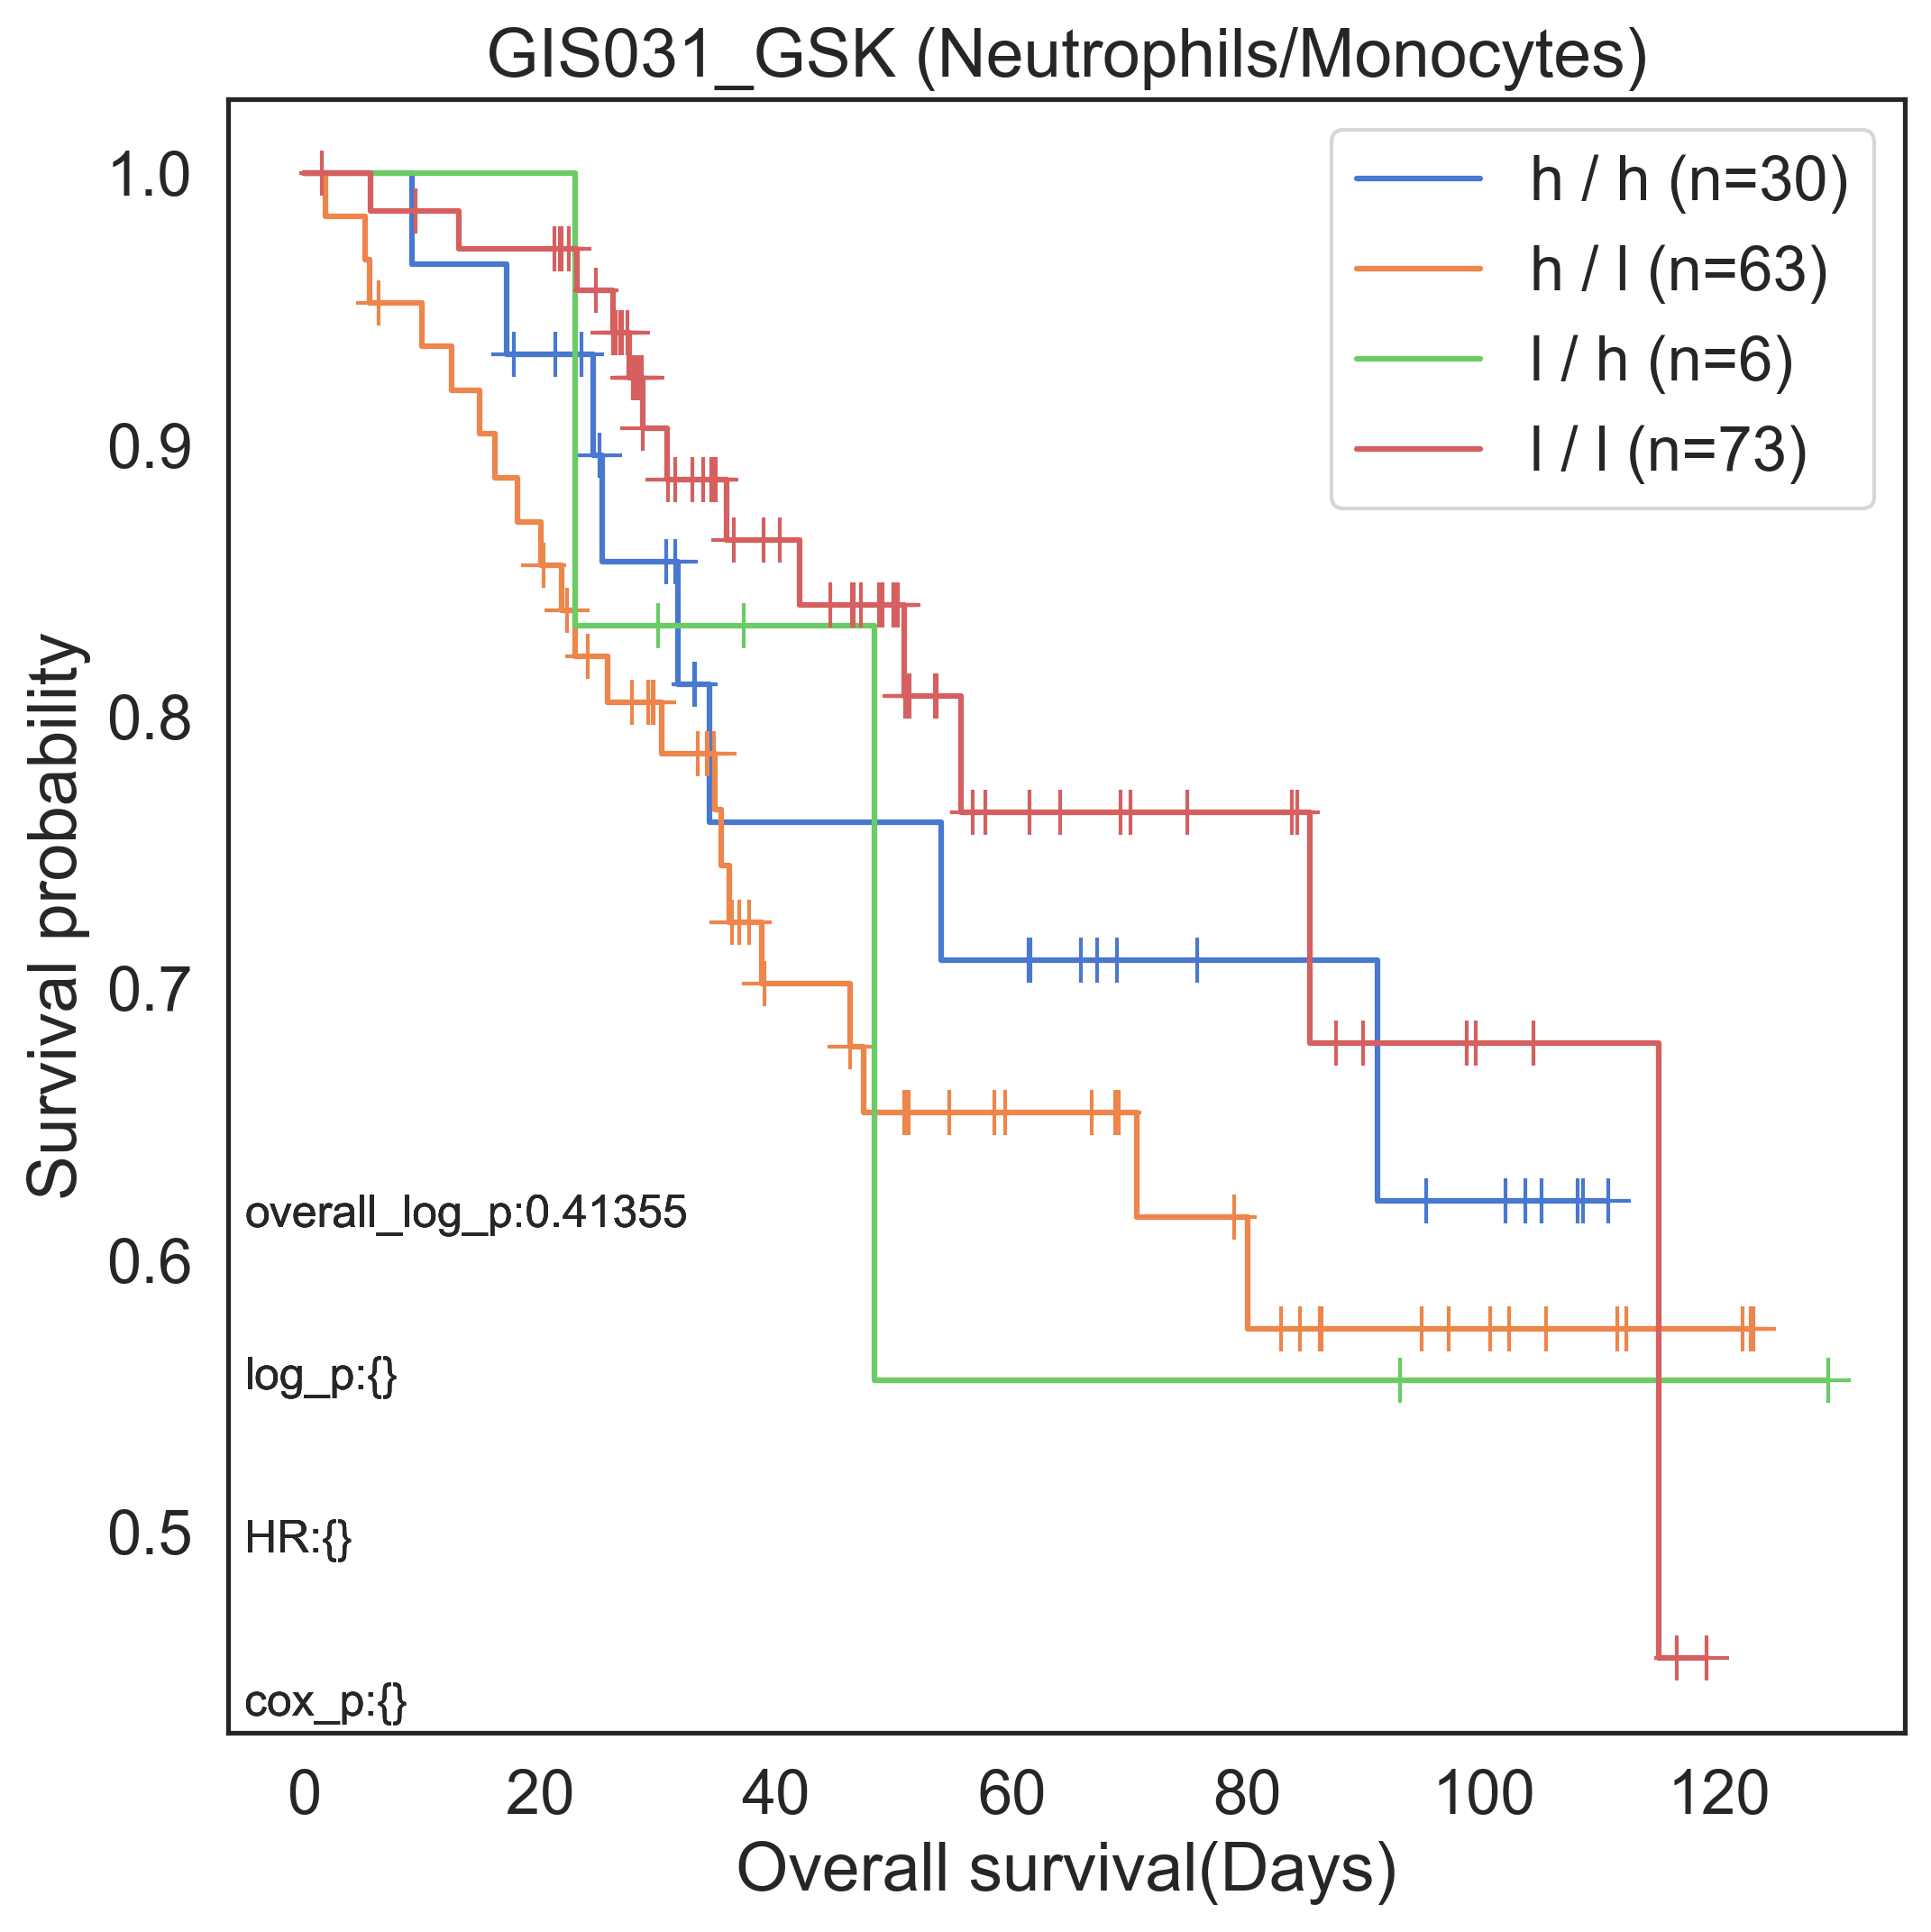

In [42]:
%%time

clinical_data_all = {}    
median_in_dataset = {}
survival_function_in_dataset = {}

sing_p_in_datasets ={}
out_p_in_datasets = {}
overall_p_in_datasets ={}
median_s_t  =pd.DataFrame()
count_double_p=0
count_except=0
significant_logrank_cox_p = pd.DataFrame()
df_hr = pd.DataFrame()
for dataset_name in beter_pre_list:
#     save_path = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\0622_4group'
#     save_path = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\0908_4group_use_new_deside_results'
#     save_path = r'D:\EMT\EMT\validation_survival_results\results\20240603_16CellType_tcfa_luad_pdf'
    save_path = r'D:\EMT\EMT\validation_survival_results\results\two_cell_types_tcga_median_cut_all_p_values'
    make_path(save_path)
    print(dataset_name,'********************************************')
    clinical_data_in_celltyppe ={}
    median_in_celltyppe  ={}
    survival_function_in_celltyppe = {}

    out_p_in_celltyppe = {}
    overall_p_value ={}   
    target_datasets=deside_predict   #deside_predict, ori_datasets
    
    X = target_datasets[dataset_name]
#     X = X.rename(columns={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'Mac'})   # alter name of some cell types 
    X = X.rename(columns={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'mø','CD4 T':'C4','CD8 T':'C8','B Cells':'B'})

#     cancer_meidan = X.median()
    cancer_meidan = median_tcga   #use TCGA LUAD threshold (median)
    cancer_meidan_path = os.path.join(save_path,'result_data','cellfrac',f'{dataset_name}')
    make_path(cancer_meidan_path)
    cancer_meidan_path = os.path.join(cancer_meidan_path,'ct_median.xlsx')
    cancer_meidan.to_excel(cancer_meidan_path)
    
    com2=combinations(X.columns, 2)
    
    p_df = pd.DataFrame()
    median_celltype = pd.DataFrame()

    
    count_index = 0

    for ct_list in com2:
        print(ct_list)



        ct_i_list= {}

        list_vital_status=[]
        list_min_T_C =[]
        list_group =[]

        out_p_list ={}
        out_cox_p ={}
        out_HR = {}
        
        sub_clinical_data={}
        sub_survival_function = {}

        for ct_i in ct_list:






#             media_ct_i = np.percentile(X.loc[:,ct_i], 50)
            media_ct_i = cancer_meidan[0][ct_i]  ##use TCGA LUAD threshold (median)
            ct_i_list[ct_i]=media_ct_i
        media1_name = list(ct_i_list.keys())[0]
        media2_name = list(ct_i_list.keys())[1]
        media1_value = ct_i_list[list(ct_i_list.keys())[0]]
        media2_value = ct_i_list[list(ct_i_list.keys())[1]]
        median_celltype.loc[dataset_name,media1_name] = media1_value
        median_celltype.loc[dataset_name,media2_name] = media2_value

        hh = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
        hl = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
        lh = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
        ll = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
        print(ct_list,'~~~~~~~~~~~~~~~~~~~~~~')
        print('Data number before filtering:',len(hh)+len(hl)+len(lh)+len(ll))
        print('hh')
        hh = delet_miss_in_clinical(hh,clinical_df=sur_GIS031_GSK)  #clinical_df=sur_GIS031_GSK
        print('hl')
        hl = delet_miss_in_clinical(hl,clinical_df=sur_GIS031_GSK)  #,clinical_df=sur_GIS031_GSK
        print('lh')
        lh = delet_miss_in_clinical(lh,clinical_df=sur_GIS031_GSK)  #,clinical_df=sur_GIS031_GSK
        print('ll')
        ll = delet_miss_in_clinical(ll,clinical_df=sur_GIS031_GSK)   #,clinical_df=sur_GIS031_GSK
        print('Data number after filtering:',len(hh)+len(hl)+len(lh)+len(ll))

        zip_cluster = {'hh':hh,'hl':hl,'lh':lh,'ll':ll}


        list_vital_status = list(hh['vital_status'])+ list(hl['vital_status'])+list(lh['vital_status'])+list(ll['vital_status']) #used for caculating the general p_value
        list_min_T_C = list(hh['min(T,C)'])+ list(hl['min(T,C)'])+list(lh['min(T,C)'])+list(ll['min(T,C)'])          #used for caculating the general p_value
        list_group = ['hh']*len(hh['min(T,C)']) + ['hl']*len(hl['min(T,C)']) + ['lh']*len(lh['min(T,C)']) + ['ll']*len(ll['min(T,C)'])   #used for caculating the general p_value
        list_group_n = [0]*len(hh['min(T,C)']) + [1]*len(hl['min(T,C)']) + [2]*len(lh['min(T,C)']) + [3]*len(ll['min(T,C)'])
        list_vital_status_array = np.array(list_vital_status)
        list_min_T_C_array = np.array(list_min_T_C)
        list_group_array = np.array(list_group)

        list_cluster = ['hh','hl','lh','ll']    






        count_com5=0
        HR_com5 ={}

        com5=combinations(list_cluster, 2)
        for key_a,key_b in com5:   

            T1 = list_min_T_C_array[list_group_array==key_a]
            T2 = list_min_T_C_array[list_group_array==key_b]
            E1 = list_vital_status_array[list_group_array==key_a]
            E2 = list_vital_status_array[list_group_array==key_b]



            ######

            if (T1.shape[0]!=0)&(T2.shape[0]!=0):
                kmf = KaplanMeierFitter()
                kmf.fit(zip_cluster[key_a]['min(T,C)'], zip_cluster[key_a]['vital_status'])  #str(len(sub_clinical['min(T,C)'])) #data_race['min(T,C)'][[0,1,2,4]]                       
                median_a = np.round((kmf.median_survival_time_)/365,2)     

                kmf = KaplanMeierFitter()
                kmf.fit(zip_cluster[key_b]['min(T,C)'], zip_cluster[key_b]['vital_status'])  #str(len(sub_clinical['min(T,C)'])) #data_race['min(T,C)'][[0,1,2,4]]                       
                median_b = np.round((kmf.median_survival_time_)/365,2)     


                results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)

                p_df.loc[str(count_index),'CancerType'] = dataset_name
                p_df.loc[str(count_index),'CellType'] = str(ct_list)
                p_df.loc[str(count_index),key_a+'_'+key_b] = f"{results.p_value:.1E}"                            #np.round(results.p_value,5)
                #!!!!!!!!!!!!!!!!!!!!!!!
                #calc hr



                d_a = zip_cluster[key_a]
                d_b = zip_cluster[key_b]
                d_a['group']=2  #The experimental group is labeled as "2" and serves as the numerator of the HR score.
                d_b['group']=1
                d_ab = pd.concat([d_a,d_b],axis=0,join='inner')
                d_ab = d_ab[['min(T,C)','vital_status','group']]
                try:
                    cph = CoxPHFitter()
                    cph.fit(d_ab, duration_col='min(T,C)', event_col ='vital_status')
                except:
                    count_except+=1
                    cph = CoxPHFitter(penalizer=0.1)
                    cph.fit(d_ab, duration_col='min(T,C)', event_col ='vital_status')                

                summary_  = cph.summary
                cox_p_lable = summary_['p'][0]  

                if cph.hazard_ratios_[0]<1:   
                    hr_larger_than_1 = 1/cph.hazard_ratios_[0]
    
                else:
                    hr_larger_than_1 = cph.hazard_ratios_[0]
       



                #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                if (results.p_value<=0.05)&(cox_p_lable<=0.05):

                    
                    assemble = (key_a,key_b)
                    out_p_list[assemble]=np.round(results.p_value,2)
                    out_cox_p[assemble]=np.round(cox_p_lable,2)
                    out_HR[assemble]= np.round(hr_larger_than_1,1)
                    
                count_double_p +=1
                significant_logrank_cox_p.loc[count_double_p,'Cancer type']= dataset_name
                significant_logrank_cox_p.loc[count_double_p,'Cell type']=ct_list[0]+'_'+ct_list[1]

                significant_logrank_cox_p.loc[count_double_p,'subgroup']=key_a+'_'+key_b
                significant_logrank_cox_p.loc[count_double_p,'subgroup sample number']=str(len(d_a))+'_'+str(len(d_b))
                significant_logrank_cox_p.loc[count_double_p,'subgroup median survival']=str(median_a)+'_'+str(median_b)
                significant_logrank_cox_p.loc[count_double_p,'logrank p']=results.p_value
                significant_logrank_cox_p.loc[count_double_p,'HR']=hr_larger_than_1
                significant_logrank_cox_p.loc[count_double_p,'cox_p']=cox_p_lable
   
            else:
                hr_larger_than_1 = float('-inf')
            HR_com5[key_a+'_'+key_b] = hr_larger_than_1
            df_hr.loc[dataset_name+'_'+ct_list[0]+'_'+ct_list[1],key_a+'_'+key_b]=hr_larger_than_1
            df_hr.loc[dataset_name+'_'+ct_list[0]+'_'+ct_list[1],'Cell type']=ct_list[0]+'_'+ct_list[1]
        hr_order1=sorted(HR_com5.items(),key=lambda x:x[1],reverse=False)

        hr_order = [i[0] for i in hr_order1]
        dict_hr =dict( zip(hr_order,range(1,7)))   # The maximum HR value is marked as 6, and the minimum HR value is marked as 1.
        dict_hr_ = dict( zip(range(1,7),hr_order))
        for i_ in range(1,7):
            df_hr.loc[dataset_name+'_'+ct_list[0]+'_'+ct_list[1],str(i_)] = dict_hr_[i_]


        for index_sig in significant_logrank_cox_p.loc[(significant_logrank_cox_p['Cancer type']==dataset_name)&(significant_logrank_cox_p['Cell type']==ct_list[0]+'_'+ct_list[1]),:].index:
            sig_ct = significant_logrank_cox_p.loc[index_sig,'subgroup']
            significant_logrank_cox_p.loc[index_sig,'ranking_HR']=dict_hr[sig_ct]


        set_fig_style(font_family='Arial', font_size=8)
        plt.figure(figsize=(8,8))
        for clu_name,clu_data in zip_cluster.items():

            if (clu_data['min(T,C)'].shape[0]!=0)&(clu_data['vital_status'].shape[0]!=0):
   
                legend_label=''
                if clu_name =='hh':
                    legend_label = 'h / h'
                if clu_name =='hl':
                    legend_label = 'h / l'
                if clu_name =='lh':
                    legend_label = 'l / h'
                if clu_name =='ll':
                    legend_label = 'l / l'
                kmf = KaplanMeierFitter()
                kmf.fit(clu_data['min(T,C)'], clu_data['vital_status'], label=f"{legend_label} (n={len(clu_data['min(T,C)'])})")  #str(len(sub_clinical['min(T,C)'])) #data_race['min(T,C)'][[0,1,2,4]]   
                kmf.plot(ci_show=False,show_censors=True)  #_false_interval
                median_ = kmf.median_survival_time_    
                median_s_t.loc[dataset_name,clu_name] = median_  ######

                df_survival_function = kmf.survival_function_

                
                sub_survival_function[clu_name] = df_survival_function
                plt.title(f'{dataset_name} ({media1_name}/{media2_name})')
                plt.ylabel('Survival probability')
                plt.xlabel('Overall survival(Days)')
                statistic_result = multivariate_logrank_test(list_min_T_C, list_group, list_vital_status)     
                p_value_= np.round(statistic_result.p_value,5)                 # general log rank p values

                p_df.loc[str(count_index),'general_p_value'] = p_value_


                plt.text(
                    0.01,
                    0.31,
                    (f"overall_log_p:{p_value_}"),
                    transform=plt.gca().transAxes,
                    horizontalalignment="left",
                    fontsize=12
                )

                plt.text(
                    0.01,
                    0.21,
                    (f"log_p:{out_p_list}"),
                    transform=plt.gca().transAxes,
                    horizontalalignment="left",
                    fontsize=12
                )

                plt.text(
                        0.01,
                        0.11,
                        (f"HR:{out_HR}"),
                        transform=plt.gca().transAxes,
                        horizontalalignment="left",
                        fontsize=12
                    ) 
                plt.text(
                        0.01,
                        0.01,
                        (f"cox_p:{out_cox_p}"),
                        transform=plt.gca().transAxes,
                        horizontalalignment="left",
                        fontsize=12
                    ) 



            sub_clinical_data[clu_name] = clu_data  
        count_index+=1      
        clinical_data_in_celltyppe[str(ct_list)] = sub_clinical_data
      
        survival_function_in_celltyppe[str(ct_list)] = sub_survival_function


        survival_plot_path = os.path.join(save_path,'plot_survival_curve',f'{dataset_name}')   
        make_path(survival_plot_path)
        survival_path = os.path.join(survival_plot_path,f'{str(ct_list)}.pdf')
        plt.savefig(survival_path)  


    
    p_df_path = os.path.join(survival_plot_path,dataset_name+'_p_value.xlsx')
    p_df.to_excel(p_df_path)

    median_s_t_path = os.path.join(survival_plot_path,'median_survival_time.xlsx')
    median_s_t.to_excel(median_s_t_path)

    median_ct_path = os.path.join(survival_plot_path,'median_celltype_frac.xlsx')
    median_celltype.to_excel(median_ct_path)
    

    survival_function_in_dataset[dataset_name] = survival_function_in_celltyppe
    clinical_data_all[dataset_name]= clinical_data_in_celltyppe  

 

      
significant_logrank_cox_p.loc[count_double_p,'count_except']=count_except
significant_logrank_cox_p_path =os.path.join(save_path,'significant_logrank_cox_p.xlsx')
significant_logrank_cox_p.to_excel(significant_logrank_cox_p_path)

df_hr_path = os.path.join(save_path,'df_hr.xlsx')
df_hr.to_excel(df_hr_path)
           


#### The cell composition used in the paper.

In [24]:

# Fig.4b
# target_keys_use=[
#  ('LUSC', ('CAFs', 'Neut'),'lh','hh','low_high','high_high'),
#  ('LUSC', ('CAFs','CD8 T effector'), 'hh','lh','high_high','low_high'),
#  ('BLCA',('Non-plasma B', 'Neut'),'hl','hh','high_low','high_high'),
#  ('LUAD',('MyoFb', 'Neut'),'hl','ll','high_low','low_low')
# #  ('LUSC', "('Endo', 'Fb')",'ll','lh','low_low','low_high')
#  ]

target_keys_use=[
 ('LUAD', ('Non-plasma B', 'CAFs'),'hl','ll','high_low','low_low'),
 ('LUAD', ('Double-neg-like T','DC'), 'hh','ll','high_high','low_low'),
 ('LUAD',('DC', 'Neut'),'hl','lh','high_low','low_high'),
('GIS031_GSK', ('Non-plasma B', 'CAFs'),'hl','ll','high_low','low_low'),
 ('GIS031_GSK', ('Double-neg-like T','DC'), 'hh','ll','high_high','low_low'),
 ('GIS031_GSK',('DC', 'Neut'),'hl','lh','high_low','low_high')
 #('KIRP', ('Plasma B', 'CD8 T effector'),'ll','hh','low_low','high_high')
#  ('LUSC', "('Endo', 'Fb')",'ll','lh','low_low','low_high')
 ]

##beter_pre_list=['GIS031_GSK']

#suplemental imformation




#SIb
# target_keys_use=[
#  ('KIRP', ('Plasma B', 'CD8 T effector'),'hl','hh','high_low','high_high'),
#  ('READ',('CD8 T effector','MyoFb'),'hh','lh','high_high','low_high'), 
# ('KIRP',('CD4 T','MyoFb'),'hh', 'lh', 'high_high', 'low_high'),    #'hh','hl','high_high','high_low'
# #     ('KIRP',('Endo','MyoFb'),'hh', 'lh', 'high_high', 'low_high')   #'hh','hl','high_high','high_low'
#  ]  


In [25]:
cancer_meidan_1 = median_tcga.copy()
cancer_meidan_1 = cancer_meidan_1.rename(index={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'mø','CD8 T':'C8','B Cells':'B',
                         'Non-plasma B cells':'Non-plasma B','Myofibroblasts':'MyoFb','Neutrophils':'Neut','Plasma B cells':'Plasma B'})


LUAD ********************************************
Non-plasma B CAFs
('Non-plasma B', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-75-6205', 'TCGA-75-7030']
Now,There are 145 sample 
hl
The following patients were missing in original clinical data:['TCGA-05-4410']
Now,There are 95 sample 
lh
The following patients were missing in original clinical data:['TCGA-75-6211']
Now,There are 108 sample 
ll
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-05-4395', 'TCGA-05-4244', 'TCGA-86-8281', 'TCGA-75-5122', 'TCGA-75-7031', 'TCGA-75-6207', 'TCGA-75-6203', 'TCGA-75-5126']
Now,There are 152 sample 
Data number after filtering: 500


D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarn

----------------------------x_left, x_right---------------------------------------
-12.08 253.68
LUAD ********************************************
Double-neg-like T DC
('Double-neg-like T', 'DC') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-75-6205', 'TCGA-05-4410', 'TCGA-75-6203', 'TCGA-75-7030']
Now,There are 167 sample 
hl
The following patients were missing in original clinical data:['TCGA-75-6207']
Now,There are 63 sample 
lh
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-05-4244', 'TCGA-75-5122', 'TCGA-75-5126']
Now,There are 73 sample 
ll
The following patients were missing in original clinical data:['TCGA-05-4395', 'TCGA-86-8281', 'TCGA-75-7031', 'TCGA-75-6211']
Now,There are 197 sample 
Data number after filtering: 500


D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarn

----------------------------x_left, x_right---------------------------------------
-12.08 253.68
LUAD ********************************************
DC Neut
('DC', 'Neut') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 513
hh
The following patients were missing in original clinical data:['TCGA-05-4244', 'TCGA-75-5122', 'TCGA-75-5126']
Now,There are 134 sample 
hl
The following patients were missing in original clinical data:['TCGA-80-5607', 'TCGA-75-6205', 'TCGA-05-4410', 'TCGA-75-6203', 'TCGA-75-7030']
Now,There are 106 sample 
lh
The following patients were missing in original clinical data:['TCGA-05-4395', 'TCGA-86-8281', 'TCGA-75-7031']
Now,There are 113 sample 
ll
The following patients were missing in original clinical data:['TCGA-75-6207', 'TCGA-75-6211']
Now,There are 147 sample 
Data number after filtering: 500


D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
D:\software\Miniconda\miniConda\envs\plot\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarn

----------------------------x_left, x_right---------------------------------------
-12.08 253.68
GIS031_GSK ********************************************
Non-plasma B CAFs
('Non-plasma B', 'CAFs') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
----------------------------x_left, x_right---------------------------------------
-6.463333335000001 135.730000035
GIS031_GSK ********************************************
Double-neg-like T DC
('Double-neg-like T', 'DC') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
----------------------------x_left, x_right---------------------------------------
-6.463333335000001 135.730000035
GIS031_GSK ********************************************
DC Neut
('DC', 'Neut') ~~~~~~~~~~~~~~~~~~~~~~
Data number before filtering: 172
hh
hl
lh
ll
Data number after filtering: 172
----------------------------x_left, x_right---------------------------------------

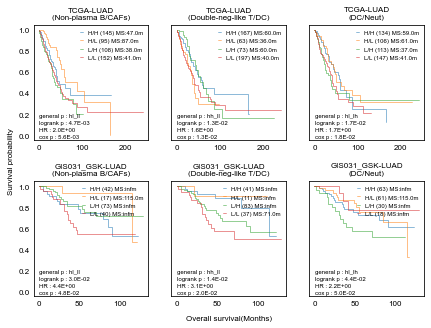

In [26]:

#plot validate data
mpl.rcParams['font.family'] = 'Arial'
sub_num = 0    #sub_num = 0  3  6   


#fig,ax = plt.subplots(3,3,figsize=(7,7.5),sharex=True, sharey=True)   #,sharey= True
n_subplots = (2,3)
fig,ax = plt.subplots(n_subplots[0],n_subplots[1],figsize=(7,5),sharey= True)   #sharex=True,,sharey= True
plt.subplots_adjust(hspace=0.35,wspace=0.2)  # wspace=0.25,
# list_a = [0,1,2,0,1,2]
# list_b = [0,0,0,1,1,1]

list_a = [0,1,2,0,1,2]
list_b = [0,0,0,1,1,1]   

for tk in target_keys_use:
#     save_path = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\0622_4group'
#     save_path = r'D:\EMT\EMT\jupyter_and_results_2022\cluster_and_survival_curve\results\all_results\0908_4group_use_new_deside_results'
    save_path = r'D:\EMT\EMT\validation_survival_results\results\wenzhan\survival_analysis'
    make_path(save_path)
    dataset_name = tk[0]
    print(dataset_name,'********************************************')
    
    if tk[0]=='LUAD':
        target_datasets=ori_datasets    #deside_predict,ori_datasets,...
    if tk[0]=='GIS031_GSK':
        target_datasets=deside_predict
    
    X = target_datasets[dataset_name]
    X = X.rename(columns={'Endothelial Cells':'Endo','Fibroblasts':'Fb','Macrophages':'mø','CD8 T':'C8','B Cells':'B',
                         'Non-plasma B cells':'Non-plasma B','Myofibroblasts':'MyoFb','Neutrophils':'Neut','Plasma B cells':'Plasma B'})   
    count_index = 0

    ct_list=tk[1]
    ct_i_list= {}
    list_vital_status=[]
    list_min_T_C =[]
    list_group =[]
    cancer_meidan = cancer_meidan_1   #median_tcga
    for ct_i in ct_list:
        
#         media_ct_i = np.percentile(X.loc[:,ct_i], 50)
        media_ct_i = cancer_meidan[0][ct_i]  ##use TCGA LUAD threshold (median)
        ct_i_list[ct_i]=media_ct_i
    media1_name = list(ct_i_list.keys())[0]
    media2_name = list(ct_i_list.keys())[1]
    print(media1_name,media2_name)
    media1_value = ct_i_list[list(ct_i_list.keys())[0]]
    media2_value = ct_i_list[list(ct_i_list.keys())[1]]

    hh = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
    hl = X.loc[(X[media1_name]>ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
    lh = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]>ct_i_list[media2_name]),:]
    ll = X.loc[(X[media1_name]<=ct_i_list[media1_name])&(X[media2_name]<=ct_i_list[media2_name]),:]
    print(ct_list,'~~~~~~~~~~~~~~~~~~~~~~')
    print('Data number before filtering:',len(hh)+len(hl)+len(lh)+len(ll))
    print('hh')
    if tk[0]=='LUAD':
        hh = delet_miss_in_clinical(hh,time_unit='change to months')
        print('hl')
        hl = delet_miss_in_clinical(hl,time_unit='change to months')
        print('lh')
        lh = delet_miss_in_clinical(lh,time_unit='change to months')
        print('ll')
        ll = delet_miss_in_clinical(ll,time_unit='change to months')
    if tk[0]=='GIS031_GSK':
        hh = delet_miss_in_clinical(hh,clinical_df=sur_GIS031_GSK)
        print('hl')
        hl = delet_miss_in_clinical(hl,clinical_df=sur_GIS031_GSK)
        print('lh')
        lh = delet_miss_in_clinical(lh,clinical_df=sur_GIS031_GSK)
        print('ll')
        ll = delet_miss_in_clinical(ll,clinical_df=sur_GIS031_GSK)        
    print('Data number after filtering:',len(hh)+len(hl)+len(lh)+len(ll))
    zip_cluster = {'hh':hh,'hl':hl,'lh':lh,'ll':ll}
    for a,b in zip_cluster.items():
        
        df_clinical_data_path = os.path.join(save_path,f'{tk[0]}_{tk[1][0]}_{tk[1][1]}_{a}_clinical_data.xlsx')
        b.to_excel(df_clinical_data_path)

    list_vital_status = list(hh['vital_status'])+ list(hl['vital_status'])+list(lh['vital_status'])+list(ll['vital_status']) #used for caculating the general p_value
    list_min_T_C = list(hh['min(T,C)'])+ list(hl['min(T,C)'])+list(lh['min(T,C)'])+list(ll['min(T,C)'])          # used for caculating the general p_value
    list_group = ['hh']*len(hh['min(T,C)']) + ['hl']*len(hl['min(T,C)']) + ['lh']*len(lh['min(T,C)']) + ['ll']*len(ll['min(T,C)'])   #sed for caculating the general p_value
    list_vital_status_array = np.array(list_vital_status)
    list_min_T_C_array = np.array(list_min_T_C)
    list_group_array = np.array(list_group)
    single_p = pd.DataFrame()
    list_cluster = ['hh','hl','lh','ll']    

    com5=combinations(list_cluster, 2)
    for key_a,key_b in com5:   
        pass






    if str(tk[1]) ==str(ct_list):




        k_a_n = tk[2]
        k_a = 2
        k_b_n = tk[3]
        k_b = 1

        df_a = zip_cluster[k_a_n]
        df_a['group'] = k_a
        df_b = zip_cluster[k_b_n]
        df_b['group'] = k_b    
        df_ab = pd.concat([df_a,df_b],join='inner',axis=0)
        df_ab = df_ab[['min(T,C)','vital_status','group']]

        cph = CoxPHFitter()
        cph.fit(df_ab, duration_col='min(T,C)', event_col ='vital_status')
        HR = cph.hazard_ratios_[0]
        summary_  = cph.summary
        cox_p_lable = summary_['p'][0] 

        if HR<1:
            HR= 1/HR
        #logrank p
        T1 = list_min_T_C_array[list_group_array==tk[2]]
        T2 = list_min_T_C_array[list_group_array==tk[3]]
        E1 = list_vital_status_array[list_group_array==tk[2]]
        E2 = list_vital_status_array[list_group_array==tk[3]]
        if (T1.shape[0]!=0)&(T2.shape[0]!=0):

            results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
            s_logrank_p = results.p_value
           #
        sub_num += 1
        sub_num1 =sub_num-1
        clu_count = 0
        for clu_name,clu_data in zip_cluster.items():
#             print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',clu_data['min(T,C)'].shape[0])

            if (clu_data['min(T,C)'].shape[0]!=0)&(clu_data['vital_status'].shape[0]!=0):

       
                legend_label=''
                if clu_name =='hh':
                    legend_label = 'H/H'
                if clu_name =='hl':
                    legend_label = 'H/L'
                if clu_name =='lh':
                    legend_label = 'L/H'
                if clu_name =='ll':
                    legend_label = 'L/L'
                #plt.sca(ax[list_a[sub_num1]])    #ax[list_b[sub_num1],list_a[sub_num1]]
                if n_subplots[0]==1:
                    plt.sca(ax[list_a[sub_num1]])   # if plt.subplots(1,*),use this line 
                    ax_subplot = ax[list_a[sub_num1]]
                else:
                    plt.sca(ax[list_b[sub_num1],list_a[sub_num1]])  # if not plt.subplots(1,*),use this line 
                    ax_subplot = ax[list_b[sub_num1],list_a[sub_num1]]                
                kmf = KaplanMeierFitter()
                kmf.fit(clu_data['min(T,C)'], clu_data['vital_status'], label=f"{legend_label} ({len(clu_data['min(T,C)'])})")  #label=f"{legend_label} (n={len(clu_data['min(T,C)'])})"   
#                 median_ = np.round((kmf.median_survival_time_)/30,0  ) 
                median_ = np.round(kmf.median_survival_time_,0  )   #已经换算成month了，不用再除以30
                kmf = KaplanMeierFitter()
                kmf.fit(clu_data['min(T,C)'], clu_data['vital_status'], label=f"{legend_label} ({len(clu_data['min(T,C)'])}) MS:{median_}m")  #label=f"{legend_label} (n={len(clu_data['min(T,C)'])})"   
                kmf.plot(ci_show=False,show_censors=False,linewidth=0.5,ax=ax_subplot)  #ax=ax[list_b[sub_num1],list_a[sub_num1]]
#                 ax[list_a[sub_num1]].legend(frameon=False,fontsize=6,handlelength=0.5,loc='upper right' )   # ax=ax[list_b[sub_num1],list_a[sub_num1]]
#                 ax[list_a[sub_num1]].set_xlabel('')   #ax=ax[list_b[sub_num1],list_a[sub_num1]]
                df_survival_function = kmf.survival_function_
                fuction_path = os.path.join(save_path,'survival_function')
                make_path(fuction_path)
                fuction_path = os.path.join(fuction_path,f'survival_function_{tk[0]}_{tk[1]}_{clu_name}.csv')
                df_survival_function.to_csv(fuction_path)
                ax_subplot.legend(frameon=False,fontsize=6,handlelength=0.5,loc='upper right' )   # ax=ax[list_b[sub_num1],list_a[sub_num1]]
                ax_subplot.set_xlabel('')   #ax=ax[list_b[sub_num1],list_a[sub_num1]]

#                 plt.title(f'{dataset_name}\n({media1_name}/{media2_name})',fontsize=8)
                if tk[0]=='LUAD':
                    tag= 'TCGA-LUAD'
                    plt.title(f'{tag}\n({media1_name}/{media2_name})',fontsize=8)
                if tk[0]=='GIS031_GSK':
                    tag = 'GIS031_GSK-LUAD'
                    plt.title(f'{tag}\n({media1_name}/{media2_name})',fontsize=8)


                statistic_result = multivariate_logrank_test(list_min_T_C, list_group, list_vital_status)     
                p_value_= np.round(statistic_result.p_value,10)                 #general p values
                df_survival_function = kmf.survival_function_
                df_survival_function_path = os.path.join(save_path,f'{tk[0]}_{tk[1][0]}_{tk[1][1]}_{clu_name}_survival_function.xlsx')
                df_survival_function.to_excel(df_survival_function_path)

                count_index+=1

                clu_count+=1
                if clu_count==4:

#                     plt.sca(ax[list_a[sub_num1]])     #  ax[list_b[sub_num1],list_a[sub_num1]]
                    if n_subplots[0]==1:
                        plt.sca(ax[list_a[sub_num1]])   # if plt.subplots(1,*),use this line 
                        
                    else:
                        plt.sca(ax[list_b[sub_num1],list_a[sub_num1]])  # if not plt.subplots(1,*),use this line 
                        
                    plt.tick_params(pad=0.5,bottom=False, top=False, left=False, right=False,labelsize=8) #
#                     plt.xlim(-200,7000)      # Change the limit of x-axis according to the desired plot.
#                     plt.xticks([0,3000,6000])
                    x_left, x_right = plt.xlim()
                    print('----------------------------x_left, x_right---------------------------------------')
                    print(x_left, x_right)
                    y_bottom, y_top = plt.ylim()
                    x_coordinate = (x_right-x_left)*0.05+x_left
                    y_coordinate = (y_top-y_bottom)*0.2+y_bottom
                    y_coordinate_2 = (y_top-y_bottom)*0.14+y_bottom
                    y_coordinate_3 = (y_top-y_bottom)*0.08+y_bottom
                    y_coordinate_4 = (y_top-y_bottom)*0.02+y_bottom
                    axes = plt.gca()
                    axes.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
                    plt.text(
                            x_coordinate,
                            y_coordinate,
                            ("general p : "+f"{tk[2]}_{tk[3]}"),  #"general Log-rank "+"$\it{p}$ = "+f"{p_value_}"
#                                 transform=plt.gca().transAxes,
                            horizontalalignment="left",
                            fontsize=6
                    )#fontsize=4
                    plt.text(
                            x_coordinate,
                            y_coordinate_2,
                            ("logrank p : "+f"{s_logrank_p:.1E}"),  #"general Log-rank "+"$\it{p}$ = "+f"{p_value_}"
#                                 transform=plt.gca().transAxes,
                            horizontalalignment="left",
                            fontsize=6
                    )#fontsize=4
                    plt.text(
                            x_coordinate,
                            y_coordinate_3,
                            ("HR : "+f"{HR:.1E}"),  #"general Log-rank "+"$\it{p}$ = "+f"{p_value_}"
#                                 transform=plt.gca().transAxes,
                            horizontalalignment="left",
                            fontsize=6
                    )#fontsize=4
                    plt.text(
                            x_coordinate,
                            y_coordinate_4,
                            ("cox p : "+f"{cox_p_lable:.1E}"),  #"general Log-rank "+"$\it{p}$ = "+f"{p_value_}"
#                                 transform=plt.gca().transAxes,
                            horizontalalignment="left",
                            fontsize=6
                    )#fontsize=4


        if sub_num1==5:   

            print('a~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            fig.add_subplot(111,frameon=False)

            plt.tick_params(pad=0.5,bottom=False, top=False, left=False, right=False) #labelsize=8
#             plt.axis('off')
            plt.xlabel('Overall survival(Months)',fontsize=8,labelpad=18)   #'Overall survival(Days)'
            plt.ylabel('Survival probability',fontsize=8,labelpad=20)
            plt.xticks([])  #去掉大图的横坐标
            plt.yticks([])
            p_f_path = os.path.join(save_path,'paper_select')   
            make_path(p_f_path)

            p_survival_path = os.path.join(p_f_path,'SI_validate_survival_1.pdf')  ########
            
            plt.savefig(p_survival_path,bbox_inches = 'tight',dpi=300) 
            plt.show()
        
